<a href="https://colab.research.google.com/github/Pixelogical/SRCNN/blob/main/SRCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
 
import os
import math
import numpy as np
 
from tensorflow import keras
from tensorflow.keras import layers
from keras.optimizers import Adam
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D, Activation, Input
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing import image_dataset_from_directory
 
from IPython.display import display
import cv2

##Load dataset from google_drive

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
!rm -rf data
!rm -rf dataset
!rm -rf SCID
!rm -rf SIQAD
!rm -rf QACS

In [ ]:
!unzip "/content/drive/MyDrive/Proposal/SCID.zip" -d "/content/SIQAD/"
# !cp /content/drive/MyDrive/ANN/Proposal/SCID/ -r /content/SCID
# !cp /content/drive/MyDrive/ANN/Proposal/QACS/QACS/ORG/ -r /content/QACS

##Create Patches from Image

In [12]:
def create_patch(img,crop_size_lr):
  numx = int(img.shape[0] / crop_size_lr)
  numy = int(img.shape[1] / crop_size_lr)
  patches = []
  for i in range(0, numx):
    startx = i * crop_size_lr
    endx = (i * crop_size_lr) + crop_size_lr
    for j in range(0, numy):
      starty = j * crop_size_lr
      endy = (j * crop_size_lr) + crop_size_lr
      if len(img.shape) == 3:
        crop_lr = img[startx:endx, starty:endy,:] 
      else:
        crop_lr = img[startx:endx, starty:endy] 
      patches.append(crop_lr)
  return patches 

In [ ]:
crop_size_lr = 16
dest_dir = 'data/train'
train_data = []
train_label = []
dataset_paths = ['QACS','SCID']
 
if not os.path.exists(dest_dir):
  os.makedirs(dest_dir)
 
nimg = 0
for dataset_path in dataset_paths:
  for n in os.listdir(dataset_path):
    if 'bmp' not in n and 'jpg' not in n and 'png' not in n:
      continue
    img = cv2.imread(os.path.join(dataset_path,n))
    img_yuv = cv2.cvtColor(img, cv2.COLOR_BGR2YUV)
    y, _, _ = cv2.split(img_yuv)

    # creating LR from Label
    small = cv2.resize(y,     (y.shape[1]//2, y.shape[0]//2), interpolation=cv2.INTER_CUBIC)
    big = cv2.resize(small,   (y.shape[1],    y.shape[0]),    interpolation=cv2.INTER_CUBIC)
    
    #cropping into pieces:
    y_patches = create_patch(y,crop_size_lr)
    for patch in y_patches:
      train_label.append(patch)
    big_patches = create_patch(big,crop_size_lr)
    for patch in big_patches:
      train_data.append(patch)
 
train_label = np.float32(train_label)
train_data = np.float32(train_data)
train_data = train_data.reshape((train_data.shape[0],crop_size_lr,crop_size_lr,1))
train_label = train_label.reshape((train_label.shape[0],crop_size_lr,crop_size_lr,1))

In [ ]:
train_data.shape

(281160, 16, 16, 1)

In [ ]:
from PIL import Image
jpeg = [[16,11,10,16,24,40,51,111],
[12,12,14,19,26,58,60,55],
[14,13,16,24,40,57,69,56],
[14,17,22,29,51,87,80,62],
[18,22,37,56,68,109,103,77],
[24,35,55,64,81,104,113,92],
[49,64,78,87,103,121,120,101],
[72,92,95,98,112,100,103,99]]
 
 
prop = [[16,10,10,10,10,10,10,10],
[10,11,11,11,11,11,11,11],
[10,11,12,12,12,12,12,12],
[10,11,12,14,14,14,14,14],
[10,11,12,14,28,28,28,28],
[10,11,12,14,28,56,56,56],
[10,11,12,14,28,56,106,106],
[10,11,12,14,28,56,106,121]]

# ******** Select Prop or Jpeg ********
quantization = prop
# ******** ******************* ********

prop= np.float32(quantization)
prop = Image.fromarray(prop)
prop = prop.resize((16, 16), Image.BILINEAR)
# prop.shape
prop = np.asarray(prop)
prop = prop.reshape((1,16,16,1))

prop.shape

(1, 16, 16, 1)

In [ ]:
def dct_2d(feature_map,norm=None):
    X1 = tf.signal.dct(feature_map, type=2, norm=norm)
    X1_t = tf.transpose(X1, perm=[0, 1, 3, 2])
    X2 = tf.signal.dct(X1_t, type=2, norm=norm)
    X2_t = tf.transpose(X2, perm=[0, 1, 3, 2])
    return X2_t
 
def idct_2d(feature_map,norm=None):
    X1 = tf.signal.idct(feature_map, type=2, norm=norm)
    X1_t = tf.transpose(X1, perm=[0, 1, 3, 2])
    X2 = tf.signal.idct(X1_t, type=2, norm=norm)
    X2_t = tf.transpose(X2, perm=[0, 1, 3, 2])
    return X2_t

In [ ]:
def myloss(y_true,y_pred):
  # quantization = np.load("quantization_34_34.npy")
  # # quantization = jpeg
 
  sr = dct_2d(y_pred)
  sr = tf.divide(sr,prop)

  hr = dct_2d(y_true)
  hr = tf.divide(hr,prop)
 
 
  # hr = y_true
  # sr = y_pred

  ee = tf.square(hr-sr)
  ee = tf.reduce_mean(ee)
  return ee

In [ ]:
# define model type
SRCNN = Sequential()
 
# add model layers
SRCNN.add(Conv2D(filters=64, kernel_size = (9, 9), kernel_initializer='glorot_uniform',
                  activation='relu', padding='same', use_bias=True, input_shape=(16,16, 1)))
SRCNN.add(Conv2D(filters=32, kernel_size = (1, 1), kernel_initializer='glorot_uniform',
                  activation='relu', padding='same', use_bias=True))
SRCNN.add(Conv2D(filters=1, kernel_size = (5, 5), kernel_initializer='glorot_uniform',
                  activation='linear', padding='same', use_bias=True))
 
# define optimizer
adam = Adam(learning_rate=0.0003)
 
SRCNN.summary()
 
# compile model
SRCNN.compile(optimizer=adam, loss='mse')

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_21 (Conv2D)           (None, 16, 16, 64)        5248      
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 16, 16, 32)        2080      
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 16, 16, 1)         801       
Total params: 8,129
Trainable params: 8,129
Non-trainable params: 0
_________________________________________________________________


In [ ]:
epochs = 1000
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=30, mode='min', restore_best_weights=True,verbose=True)

history = SRCNN.fit(
    train_data,train_label, epochs=epochs, batch_size=128, validation_split = 0.2, callbacks=[callback]
)

Epoch 1/1000
1758/1758 [==============================] - 9s 5ms/step - loss: 1605.6280 - val_loss: 383.0120
Epoch 2/1000
1758/1758 [==============================] - 9s 5ms/step - loss: 487.4034 - val_loss: 370.1242
Epoch 3/1000
1758/1758 [==============================] - 9s 5ms/step - loss: 467.0312 - val_loss: 364.9180
Epoch 4/1000
1758/1758 [==============================] - 9s 5ms/step - loss: 457.0021 - val_loss: 360.2322
Epoch 5/1000
1758/1758 [==============================] - 9s 5ms/step - loss: 447.0396 - val_loss: 367.6056
Epoch 6/1000
1758/1758 [==============================] - 9s 5ms/step - loss: 441.7519 - val_loss: 355.8019
Epoch 7/1000
1758/1758 [==============================] - 9s 5ms/step - loss: 433.2565 - val_loss: 352.1023
Epoch 8/1000
1758/1758 [==============================] - 9s 5ms/step - loss: 431.1770 - val_loss: 350.0254
Epoch 9/1000
1758/1758 [==============================] - 9s 5ms/step - loss: 427.7481 - val_loss: 348.7015
Epoch 10/1000
1758/1758 [==

Save model

In [ ]:
# SRCNN.save('/content/drive/MyDrive/ANN/Proposal/SRCNN-SRSC/6/YCHFirst_Patched16All-1000EPOCH-MSE2.h5')
# np.save('/content/drive/MyDrive/ANN/Proposal/SRCNN-SRSC/6/YCHFirst_Patched16All-1000EPOCH-MSE2.npy',history.history)

Load model

In [ ]:
SRCNN = keras.models.load_model('/content/drive/MyDrive/ANN/Proposal/SRCNN-SRSC/5/Patched16All-100EPOCH-MSE.h5',compile=False)

##Single image test

[[1. 0. 0. 0. 0. 0. 9. 9. 7. 4. 6. 6. 0. 0. 0. 2. 3. 3. 4. 0. 1.]
 [8. 7. 2. 0. 0. 0. 2. 1. 2. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 6.]]


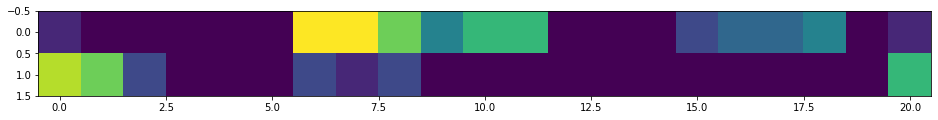

In [34]:
import cv2
from google.colab.patches import cv2_imshow
 
 
img = cv2.imread("SIQAD/references/cim1.bmp")
img_yuv = cv2.cvtColor(img, cv2.COLOR_BGR2YUV)
y, _, _ = cv2.split(img_yuv)

# creating LR from Label
small = cv2.resize(y,     (y.shape[1]//2, y.shape[0]//2), interpolation=cv2.INTER_CUBIC)
big = cv2.resize(small,   (y.shape[1],    y.shape[0]),    interpolation=cv2.INTER_CUBIC)
big_patches = create_patch(big,16)
big_patches = np.uint16(big_patches)
big_patches.shape
x = MSE.predict(big_patches.reshape((big_patches.shape[0],big_patches.shape[1],big_patches.shape[2],1)))
nx,ny = y.shape[0] // 16 , y.shape[1] // 16
x[x > 255] = 255
x[x < 0] = 0
x = np.uint16(x).reshape((nx,ny,16,16))

reconstruct = np.zeros((nx*16,ny*16))
for i in range(nx):
  for j in range(ny):
    reconstruct[i*16:i*16 + 16,j*16:j*16+16] = x[i][j]
plt.figure(figsize=(16,9))

# reconstruct[reconstruct > 255] = 255
print(reconstruct[322:324,74:95])
plt.imshow(reconstruct[322:324,74:95])

# f, axs = plt.subplots(1,3,figsize=(25,15))
# axs[0].imshow(y,cmap='gray')
# axs[1].imshow(big,cmap='gray')
# axs[2].imshow(reconstruct,cmap='gray')
 


##Batch image test

In [10]:
MSE = keras.models.load_model('/content/drive/MyDrive/ANN/Proposal/SRCNN-SRSC/6/YCHFirst_Patched16All-1000EPOCH-MSE.h5',compile=False)
JPEG = keras.models.load_model('/content/drive/MyDrive/ANN/Proposal/SRCNN-SRSC/6/YCHFirst_Patched16All-1000EPOCH-JPEG.h5',compile=False)
PROP = keras.models.load_model('/content/drive/MyDrive/ANN/Proposal/SRCNN-SRSC/6/YCHFirst_Patched16All-1000EPOCH-PROP.h5',compile=False)

In [35]:
dataset_path = 'SIQAD/references'
version = '6'

if not os.path.exists(version):
  os.makedirs(version)

 

for n in os.listdir(dataset_path):
  if 'bmp' not in n and 'jpg' not in n and 'png' not in n:
    continue
  img = cv2.imread(os.path.join(dataset_path,n))
  img_yuv = cv2.cvtColor(img, cv2.COLOR_BGR2YUV)
  y, _, _ = cv2.split(img_yuv)

  # creating LR from Label
  small = cv2.resize(y,     (y.shape[1]//2, y.shape[0]//2), interpolation=cv2.INTER_CUBIC)
  big = cv2.resize(small,   (y.shape[1],    y.shape[0]),    interpolation=cv2.INTER_CUBIC)
  
  big_patches = create_patch(big,16)
  big_patches = np.uint16(big_patches)
  mse = MSE.predict(big_patches.reshape((big_patches.shape[0],big_patches.shape[1],big_patches.shape[2],1)))
  jpeg = JPEG.predict(big_patches.reshape((big_patches.shape[0],big_patches.shape[1],big_patches.shape[2],1)))
  prop = PROP.predict(big_patches.reshape((big_patches.shape[0],big_patches.shape[1],big_patches.shape[2],1)))
  
  nx,ny = y.shape[0] // 16 , y.shape[1] // 16

  mse[mse > 255] = 255
  mse[mse < 0] = 0
  jpeg[jpeg > 255] = 255
  jpeg[jpeg < 0] = 0
  prop[prop > 255] = 255
  prop[prop < 0] = 0
  mse = np.uint16(mse).reshape((nx,ny,16,16))
  jpeg = np.uint16(jpeg).reshape((nx,ny,16,16))
  prop = np.uint16(prop).reshape((nx,ny,16,16))

  reconstruct_mse = np.zeros((nx*16,ny*16))
  reconstruct_jpeg = np.zeros((nx*16,ny*16))
  reconstruct_prop = np.zeros((nx*16,ny*16))

  for i in range(nx):
    for j in range(ny):
      reconstruct_mse[i*16:i*16 + 16,j*16:j*16+16] = mse[i][j]
      reconstruct_jpeg[i*16:i*16 + 16,j*16:j*16+16] = jpeg[i][j]
      reconstruct_prop[i*16:i*16 + 16,j*16:j*16+16] = prop[i][j]


  reconstruct_mse[reconstruct_mse > 255] = 255
  reconstruct_jpeg[reconstruct_jpeg > 255] = 255
  reconstruct_prop[reconstruct_prop > 255] = 255

  cv2.imwrite('{}/{}_GT.bmp'.format(version,n),y[:nx*16,:ny*16])
  cv2.imwrite('{}/{}_MSE.bmp'.format(version,n),reconstruct_mse)
  cv2.imwrite('{}/{}_JPEG.bmp'.format(version,n),reconstruct_jpeg)
  cv2.imwrite('{}/{}_PROP.bmp'.format(version,n),reconstruct_prop)
  print(f'{n} is saved.')

  # plt.figure(figsize=(16,9))

cim5.bmp is saved.	cim3.bmp is saved.	cim1.bmp is saved.	cim15.bmp is saved.	cim9.bmp is saved.	cim2.bmp is saved.	cim10.bmp is saved.	cim16.bmp is saved.	cim6.bmp is saved.	cim7.bmp is saved.	cim17.bmp is saved.	cim4.bmp is saved.	cim8.bmp is saved.	cim11.bmp is saved.	cim20.bmp is saved.	cim14.bmp is saved.	cim18.bmp is saved.	cim12.bmp is saved.	cim13.bmp is saved.	cim19.bmp is saved.	

In [36]:
!zip -r '6.zip' '6'

  adding: 6/ (stored 0%)
  adding: 6/cim13.bmp_GT.bmp (deflated 64%)
  adding: 6/cim6.bmp_JPEG.bmp (deflated 32%)
  adding: 6/cim5.bmp_PROP.bmp (deflated 42%)
  adding: 6/cim9.bmp_PROP.bmp (deflated 29%)
  adding: 6/cim3.bmp_JPEG.bmp (deflated 44%)
  adding: 6/cim3.bmp_GT.bmp (deflated 76%)
  adding: 6/cim12.bmp_JPEG.bmp (deflated 20%)
  adding: 6/cim15.bmp_PROP.bmp (deflated 47%)
  adding: 6/cim18.bmp_JPEG.bmp (deflated 20%)
  adding: 6/cim15.bmp_MSE.bmp (deflated 48%)
  adding: 6/cim13.bmp_MSE.bmp (deflated 40%)
  adding: 6/cim19.bmp_PROP.bmp (deflated 22%)
  adding: 6/cim3.bmp_PROP.bmp (deflated 45%)
  adding: 6/cim4.bmp_PROP.bmp (deflated 42%)
  adding: 6/cim2.bmp_GT.bmp (deflated 85%)
  adding: 6/cim16.bmp_GT.bmp (deflated 69%)
  adding: 6/cim7.bmp_PROP.bmp (deflated 61%)
  adding: 6/cim1.bmp_GT.bmp (deflated 71%)
  adding: 6/cim3.bmp_MSE.bmp (deflated 46%)
  adding: 6/cim14.bmp_PROP.bmp (deflated 42%)
  adding: 6/cim1.bmp_JPEG.bmp (deflated 41%)
  adding: 6/cim7.bmp_MSE.bmp (defl